# Определение токсичных комментариев с использованием BERT

## Описание проекта

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Имеется набор данных с разметкой о токсичности комментариев.

### Цель проекта

Построить модель классификации комментариев на позитивные (нормальные) и негативные (токсичные).

Значение метрики качества *F1* должно быть не меньше 0.75. 

### Задачи проекта

1. Загрузить и подготовить данные.

2. Обучить разные модели классификации на данных.

3. Проанализировать результаты и сделать выводы.

### Описание данных

Данные находятся в файле [`toxic_comments.csv`](https://<LINK_REMOVED>/datasets/toxic_comments.csv). 

- столбец `text` содержит текст комментария;
- столбец `toxic` — целевой признак.

### Установка и обновление библиотек

In [1]:
# обновляем версии библиотек и устанавливаем дополнительные библиотеки
%pip install matplotlib==3.7.3 seaborn==0.13.1 scikit-learn==1.6.1 \
    lightgbm==4.6.0 catboost==1.2.8 langid==1.1.6 shap==0.46.0 \
    torch==2.6.0 transformers==4.49.0 \
    --resume-retries 2 --quiet

Note: you may need to restart the kernel to use updated packages.


### Импорты

In [2]:
import os
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
import shap
from tqdm.auto import tqdm

# для обработки текстов
from langid.langid import (
    LanguageIdentifier, 
    model as langid_model
)
import torch
from transformers import BertTokenizer, BertModel

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    confusion_matrix
)

# классы моделей
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier

### Настройки

In [3]:
# фиксируем случайное состояние
RANDOM_STATE = 42

# размер выборки
SAMPLE_SIZE = 10240
# размер батча
BATCH_SIZE = 256

# использовать ли готовые результаты вычислений
USE_PRECOMPUTED_HYPERPARAMETERS = True

In [4]:
# отображать таблицы pandas полностью
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# инициализируем индикатор прогресса в pandas
tqdm.pandas()

### Пользовательские функции

In [6]:
def custom_histplot(data, column, target, **kwargs):
    """
    Строит гистограмму распределения для количественного признака 'column'
    с разбивкой по целевому признаку 'target'.
    """

    # дискретность признака
    discrete = True if data[column].dtype == 'int64' else False

    # строим гистограммы распределения
    ax = sns.histplot(
        data=data,
        x=column, 
        hue=target,
        discrete=discrete, 
        stat='percent', 
        common_norm=False, 
        **kwargs
    )

    # добавляем линии: среднее и медиана
    colors = colormaps['tab10'].colors
    line_labels = []
    line_handles = []
    for u, color in zip(data[target].unique(), colors):
        vl1 = ax.axvline(
            x=data.loc[data[target] == u, column].mean(), 
            color=color, 
            linestyle='-',
        )
        line_labels.append('Среднее ({}: {})'.format(target, str(u)))
        line_handles.append(vl1)
        vl2 = ax.axvline(
            x=data.loc[data[target] == u, column].median(), 
            color=color, 
            linestyle='--',
        )
        line_labels.append('Медиана ({}: {})'.format(target, str(u)))
        line_handles.append(vl2)

    # добавляем легенду
    handles = ax.get_legend().legend_handles
    labels = data[target].unique().tolist()
    ax.legend(
        handles=handles+line_handles, 
        labels=labels+line_labels,
        title=target,
    )

    ax.set_ylabel('Доля (%)')
    ax.set_title('Гистограмма распределения с разбивкой по целевому признаку')

    return ax


In [7]:
def plot_class_balance(target: pd.Series):
    """
    Строит диаграмму распределения классов по целевому признаку.
    """
    # строим график
    ax = sns.countplot(x=target, hue=target, stat='percent', legend=False)

    # добавляем аннотации
    for c in ax.containers:
        ax.bar_label(c, label_type='center', fmt='{:.2f} %')
    
    # оформляем график
    ax.set_ylabel('Доля (%)')
    ax.set_title('Распределение классов по целевому признаку')

    return ax

In [8]:
def plot_confusion_matrix(y_true, y_pred, normalize=None):
    """
    Строит матрицу ошибок модели классификации.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    fmt = 'd' if normalize is None else '.2%'

    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues_r', cbar=False)

    ax.set_xlabel('Предсказанное значение')
    ax.set_ylabel('Истинное значение')
    ax.set_title('Матрица ошибок модели')

    return ax

In [9]:
def plot_feature_importance(importance, feature_names, limit=None):
    """
    Строит график важности признаков.
    """
    # формируем таблицу
    feature_df = (
        pd.DataFrame({'признак': feature_names, 'значение': importance})
        .sort_values(by='значение', key=lambda x: abs(x), ascending=False)
        .head(limit)
        .reset_index(drop=True)
    )
    # визуализируем данные в таблице
    ax = sns.barplot(data=feature_df, x='значение', y='признак')

    return ax

## Обзор данных

### Загрузка данных

In [10]:
# имя файла с данными
file_name = 'toxic_comments.csv'

# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
    source = 'по умолчанию'
elif os.path.exists(path_local):
    path = path_local_rel
    source = 'локальный путь'
else:
    path = path_remote
    source = 'сетевой путь'
full_path = os.path.join(path, file_name)
# загрузка данных из CSV файла
data = pd.read_csv(full_path)

print(f'Данные успешно загружены из файла: {full_path} ({source})')

Данные успешно загружены из файла: ~/datasets/toxic_comments.csv (локальный путь)


### Знакомство с данными

In [11]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [12]:
print('Уникальные значения целевого признака:',
      data['toxic'].unique().tolist())

Уникальные значения целевого признака: [0, 1]


Датасет содержит тексты 159292 комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0).

Предсказание целевого признака, принимающего значения 0 и 1 — это задача бинарной классификации.

In [13]:
# первые 10 строк таблицы
data.head(10)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


### Выводы

1. Датасет содержит тексты более 159 тысяч комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0). 

2. Предсказание целевого признака, принимающего значения 0 и 1 — это задача **бинарной классификации**.

## Исследовательский анализ данных

### Длина текстов

Исследуем распределение текстов по длине (количеству слов), чтобы понять, как много длинных текстов в корпусе.

In [14]:
# добавляем столбец с количеством слов в тексте
data['num_words'] = data['text'].apply(lambda x: len(x.split()))

In [15]:
# статистика по количеству слов в текстах
data[['num_words']].describe().T

,count,mean,std,min,25%,50%,75%,max
num_words,159292.0,67.213545,99.133908,1.0,17.0,36.0,75.0,1411.0


Модель BERT позволяет получить эмбеддинги для текстов не длиннее 512 токенов (510 + 2 специальных токена для начала и конца текста).

In [16]:
print('Доля текстов, в которых больше 510 слов: ', 
      f"{(data['num_words'] > 510).mean():.2%}")

Доля текстов, в которых больше 510 слов:  1.25%


Как правило, одному слову соответствует один токен, но в некоторых случаях одно слово может быть разделёно на несколько токенов. Поэтому доля текстов, которые содержат более 512 токенов, может быть больше этого значения.

Визуализируем распределение текстов количеству слов с помощью диаграммы размаха и гистограммы.

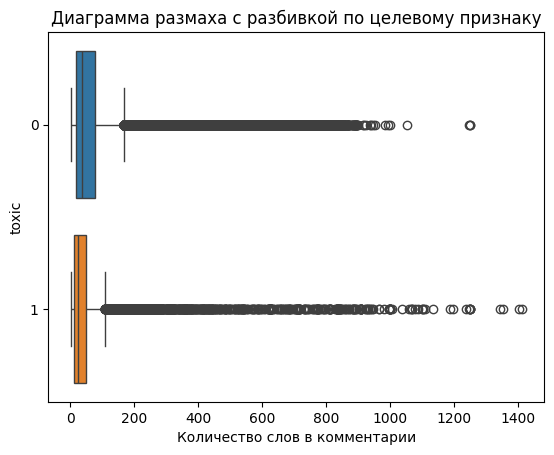

In [17]:
# строим диаграмму размаха с разбивкой по целевому признаку
sns.boxplot(data=data, x='num_words', y='toxic', hue='toxic', orient='h', legend=False)

plt.xlabel('Количество слов в комментарии')
plt.title('Диаграмма размаха с разбивкой по целевому признаку');

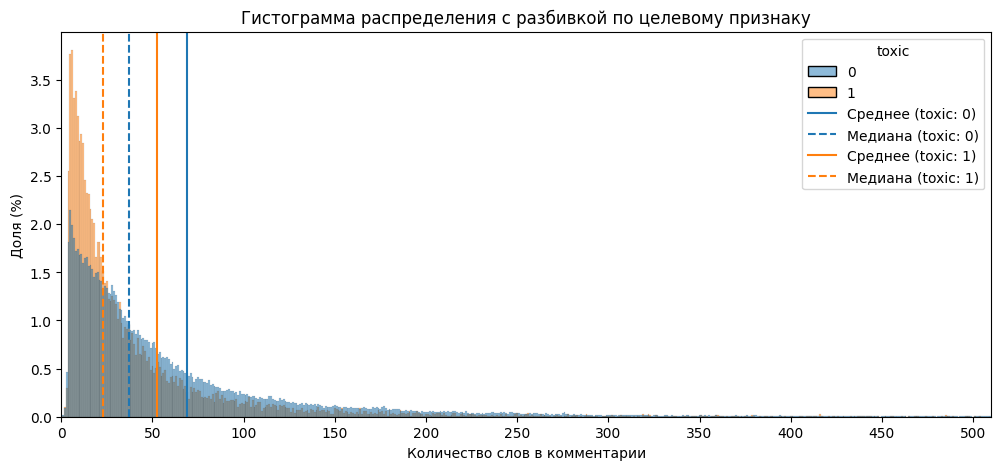

In [18]:
# строим гистограмму распределения количества слов в комментариях
# с разбивкой по целевому признаку
fig, ax = plt.subplots(figsize=(12, 5))
custom_histplot(data, 'num_words', target='toxic', ax=ax)
plt.xlim(0, 510)
plt.xticks(range(0, 510, 50))
plt.xlabel('Количество слов в комментарии');

- Длинные тексты довольно редки, но тем не менее они есть, и их количество плавно уменьшается по мере увеличения длины.

- Распределения отличаются для токсичных и нормальных комментариев: среди токсичных комментариев значительно больше коротких длиной менее 20 слов.

Поэтому далее имеет смысл добавить к данным признак длины текста в словах. Он может помочь лучше различать токсичные и нормальные комментарии.

### Баланс классов

Исследуем баланс классов в данных. Для этого построим диаграмму распределения классов по значению целевого признака с помощью пользовательской функции `plot_class_balance()`.

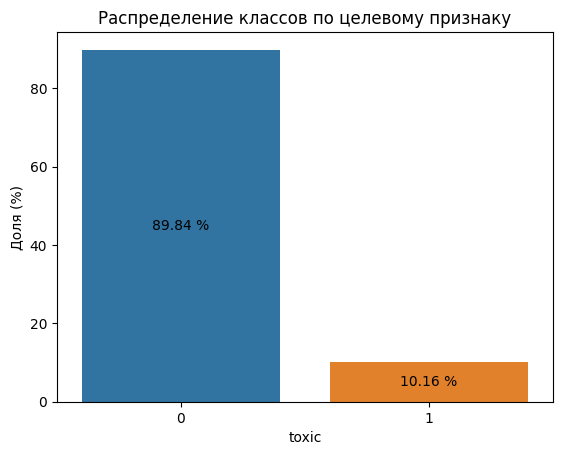

In [19]:
# строим диаграмму распределения
plot_class_balance(data['toxic']);

В данных имеется значительный дисбаланс классов: доля токсичных комментариев составляет всего ≈10%. Этот факт нужно будет учесть при подготовке выборок и построении ML моделей.

### Выводы

1. Распределение комментариев по количеству слов в них отличается для токсичных и нетоксичных комментариев: среди токсичных комментариев значительно больше коротких длиной менее 20 слов. Поэтому далее имеет смысл добавить к данным признак длины текста в словах. Он может помочь лучше различать токсичные и нормальные комментарии.

2. Обнаружен **дисбаланс классов** по значению целевого признака: доля токсичных комментариев составляет всего ≈10%. Этот факт нужно учитывать при подготовке данных и построении ML моделей.

## Подготовка данных

### Удаление лишнего столбца

В исходном датасете имеется лишний безымянный столбец. Видимо, это значения индекса. Они не несут полезной информации, поэтому этот столбец можно удалить.

In [20]:
# удаляем лишний столбец
data = data.drop(columns=data.columns[0])

### Очистка текстов

Проведём предварительную очистку текстов.

Приведём тексты к нижнему регистру и очистим их от URL, email и небуквенных символов. Для этого используем функцию `clean_text()`.

In [21]:
def clean_text(text):
    """
    Приводит текст к нижнему регистру и
    очищает от URL, email, небуквенных символов.
    """
    # приводим к нижнему регистру
    clean = text.lower()

    # удаляем  URL и email
    clean = re.sub(r'(f|ht)tps?://\S+|www\.\S+|\S+@\S+\.\S+', '', clean)

    # удаляем теги HTML
    clean = re.sub(r'<[^>]*>', ' ', clean)

    # удаляем IP адреса
    clean = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', ' ', clean)

    # удаляем экранированные специальные символы
    clean = re.sub(r'\\.', ' ', clean)

    # удаляем лишние пробелы
    clean = ' '.join(clean.split())

    # возвращаем None, если получилась пустая строка
    return clean or None

In [22]:
# очищаем тексты
data['clean_text'] = data['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

После очистки текстов могли появиться пропущенные значения (пустые комментарии).

In [23]:
print('Количество пустых комментариев после очистки текста: '
      f"{data['clean_text'].isna().sum()}")

Количество пустых комментариев после очистки текста: 11


Удалим записи с пропущенными значениями из данных.

In [24]:
# удаляем записи с пустыми текстами
data = data.dropna().reset_index(drop=True)

### Определение языка текстов

Как показало знакомство с данными, первые 10 комментариев написаны на английском языке. Но исследовать вручную все 159 тысяч текстов невозможно, поэтому нужно использовать средства автоматического определения языка текста.

Для определения языка комментариев используем библиотеку `langid`. Функция `classify()` позволяет определить вероятный язык текста и вероятность принадлежности текста к этому языку.

Если вероятность не превышает 0.5, то будем считать определение неуверенным и вместо кода языка установим значение `not sure` ("не уверен").

Если окажется, что в корпусе присутствуют тексты на разных языках, то их нужно будет обрабатывать раздельно. И модели лучше строить отдельные для каждого языка.

Процедура определения языка текстов в большом корпусе — вычислительно затратная, поэтому для ускорения повторных запусков кода сохраним результаты в файл. 

In [25]:
# инициализируем определитель языка
language_identifier = LanguageIdentifier.from_modelstring(langid_model, norm_probs=True)

In [26]:
def guess_language(text):
    """
    Определяет язык текста. 
    Возвращает двухбуквенный код языка или 'not sure',
    если вероятность принадлежности текста к этому языку не превышает 0.5.
    """
    lang_result = language_identifier.classify(text)

    return 'not sure' if lang_result[1] <= 0.5 else lang_result[0]

In [27]:
# файл с результатами определения языка
backup_file = 'lang.csv'

# использовать готовые результаты в случае их наличия
try:
    # загружаем данные из файла
    data['lang'] = pd.read_csv(backup_file)
except FileNotFoundError:
    # определяем язык текстов
    data['lang'] = data['clean_text'].progress_apply(guess_language)
    # сохраняем результаты в файл
    data['lang'].to_csv(backup_file, index=False)

Посмотрим на результаты определения языка текстов. Выведем топ-10 языков.

In [28]:
# выводим топ-10 языков
(data['lang']
 .value_counts(normalize=True)
 .head(10)
 .to_frame()
 .style.format('{:.2%}')
)

,lang
en,97.11%
not sure,1.14%
it,0.16%
de,0.13%
fr,0.13%
la,0.12%
id,0.11%
es,0.10%
nl,0.10%
mt,0.07%


Более 97% текстов на английском языке. Для чуть более 1% текстов уверенно определить язык не удалось. 

Остальные языки имеют незначительные доли. Проверим, не ошибки дли это. Для примера посмотрим тексты, язык которых был определён как `it` — итальянский.

In [29]:
# выводим первые 10 текстов, язык которых был определён как итальянский
data.loc[data['lang'] == 'it', ['clean_text']].head(10)

,clean_text
3165,"la vierge au voile, by raffaello sanzio, from c2rmf retouched"
3216,"}} {{image requested|in=collin county, texas|of=headquarters, 7100 corporate drive plano, texas 75024, united states"
4026,redirect talk:sun hwa (filipino school)
4246,faggot faggot faggot faggot
4712,firearms 2 (computer game) deletion question i responded. — talk
6258,"aggie pool pool/spa maintenance. cleaning, chemicals, equipment problems. open 9-5 everyday 281-610-3469"
6376,redirect talk:the doha debates
6662,", more like gayfagonaplane"
8126,i don't believe you're a faggot. you're more like a eurotoxin douche.
9450,new delete petar_brzica article nomination see


Очевидно, что все эти тексты на английском языке. 

Будем считать, что все тексты в корпусе на английском языке, а определённая классификатором принадлежность текстов к другим языкам — ошибка. Поэтому далее используем модель BERT, рассчитанную на английский язык.

Проверим результаты обработки данных.

In [30]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159281 entries, 0 to 159280
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159281 non-null  object
 1   toxic       159281 non-null  int64 
 2   num_words   159281 non-null  int64 
 3   clean_text  159281 non-null  object
 4   lang        159281 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.1+ MB


In [31]:
# выводим 5 случайных записей
data.sample(n=5, random_state=RANDOM_STATE)

,text,toxic,num_words,clean_text,lang
89052,So I request to be unblocked.}},0,6,so i request to be unblocked.}},en
127199,"==Wikipedia Withdrawal\n\nTo Katefan0,\n\nI have come to the conclusion that Wikipedia is no different than any other source of misinformation. My intentions of contributing to the Whitman article was due to my involvement with the officer who killed Whitman and numerous victims, professors, witnesses and news media outlets. But Alas, I find myself, as Gulliver, lost among a few Yahoos whose intentions appear to be to their own speculation and interpretation of Charles Whitman and The University of Texas Tower Tragedy. Their abuse of sources shows their willingness to subscribe to editing and rules, in the face of facts and researched knowledge. They are pedantic and callous, and I unfortunately have joined them at their own level; I must now re-elevate myself and return to the dictates of logic and critical thinking, something that my experience on Wikipedia has deluted. I will return to my original research and take the experience of Wikipedia as a lesson; that no matter how much experience and involvement a person has on a particular subject, there are always those who no nothing, willing to reduce your efforts to elevate their own egos and ambitions. I will take away all my contributions. I realize they will be re-inserted for the Yahoos benefit, but that will be out of my hands! I would wish you good luck, however, you are going to need something much more powerful than luck to ever make this article correct! Subwayjack",0,241,"==wikipedia withdrawal to katefan0, i have come to the conclusion that wikipedia is no different than any other source of misinformation. my intentions of contributing to the whitman article was due to my involvement with the officer who killed whitman and numerous victims, professors, witnesses and news media outlets. but alas, i find myself, as gulliver, lost among a few yahoos whose intentions appear to be to their own speculation and interpretation of charles whitman and the university of texas tower tragedy. their abuse of sources shows their willingness to subscribe to editing and rules, in the face of facts and researched knowledge. they are pedantic and callous, and i unfortunately have joined them at their own level; i must now re-elevate myself and return to the dictates of logic and critical thinking, something that my experience on wikipedia has deluted. i will return to my original research and take the experience of wikipedia as a lesson; that no matter how much experience and involvement a person has on a particular subject, there are always those who no nothing, willing to reduce your efforts to elevate their own egos and ambitions. i will take away all my contributions. i realize they will be re-inserted for the yahoos benefit, but that will be out of my hands! i would wish you good luck, however, you are going to need something much more powerful than luck to ever make this article correct! subwayjack",en
1045,You go away you loser. Way to standup for you boyfriend Blueboy96. Make me go away.,1,16,you go away you loser. way to standup for you boyfriend blueboy96. make me go away.,en
80668,"Thanks, 5. Funny thing is, the IP with the most edits, one of them actually (partially) reverted vandalism in an article where I just blocked two accounts. Well, we'll see. The Ninja article is semi-protected, and we'll just have to see if it gets bad. I appreciate the help,",0,49,"thanks, 5. funny thing is, the ip with the most edits, one of them actually (partially) reverted vandalism in an article where i just blocked two accounts. well, we'll see. the ninja article is semi-protected, and we'll just have to see if it gets bad. i appreciate the help,",en
37563,Whoops \n\nDidn't notice that Taiketsu had already submitted a request. \,0,11,whoops didn't notice that taiketsu had already submitted a request. \,en


Пропущенные значения отсутствуют, результаты обработки текстов соответствуют ожидаемым.

Сохраним подготовленные данные в файл.

In [32]:
# сохраняем данные в файл
data[['clean_text', 'toxic']].to_csv('toxic_comments_cleaned.csv', index=False)

### Создание эмбеддингов для текстов с помощью BERT

Для получения признаков, по которым тексты комментариев будут классифицироваться на токсичность, используем предобученную языковую модель BERT (Bidirectional Encoder Representations from Transformers) из библиотеки `transformers`. Признаками для моделей классификации будут служить эмбеддинги CLS-токена каждого текста, полученные из BERT, которые характеризуют смысл текста в целом.

Сначала токенизируем тексты комментариев с помощью `BertTokenizer`, а затем получим эмбеддинги CLS-токена для каждого текста с помощью `BertModel`.

In [33]:
# название модели
model_name = 'bert-base-uncased'

# инициализируем токенизатор
tokenizer = BertTokenizer.from_pretrained(model_name)

# инициализируем модель
model = BertModel.from_pretrained(model_name)

Чтобы ускорить вычисления, можно использовать GPU с поддержкой CUDA. 

In [34]:
# Проверяем доступность CUDA и выбираем устройство для вычислений
if torch.cuda.is_available():
    device = torch.device('cuda')
    model.to(device)
    print(f'Используем CUDA: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print('CUDA не доступна, используем CPU')

CUDA не доступна, используем CPU


Для ускорения вычислений предварительно скомпилируем модель.

In [35]:
# компилируем модель
model = torch.compile(model)

Токенизация и вычисление эмбеддингов для большого корпуса текстов занимают очень много времени. Поэтому используем не весь корпус, а выборку из него, стратифицированную по целевому признаку (токсичности комментария).

In [36]:
# делаем стратифицированную выборку из данных
_, data_sample = train_test_split(
    data, 
    test_size=SAMPLE_SIZE, 
    stratify=data['toxic'], 
    random_state=RANDOM_STATE
)
del _
data_sample.reset_index(drop=True, inplace=True)

Проверим стратифицированность выборки по целевому признаку.

In [37]:
# доли значений признака 'toxic'
data_sample['toxic'].value_counts(normalize=True).round(4)

0    0.8983
1    0.1017
Name: toxic, dtype: float64

Токенизация текстов — вычислительно затратный процесс. Поэтому при наличии уже готовых результатов токенизации их можно загрузить из файла.

In [38]:
# файл с результатами токенизации текстов
backup_file = 'bert_inputs.pt'

# использовать уже рассчитанные входные данные в случае их наличия
try:
    inputs = torch.load(
        backup_file,
        map_location=device,
        weights_only=False,
    )
    print("Входные данные для модели загружены из файла.")
except FileNotFoundError:
    # токенизируем тексты
    inputs = tokenizer(
        data_sample['clean_text'].tolist(),
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=512,
    ).to(device)
    torch.save(inputs, backup_file)
    print("Входные данные для модели рассчитаны и сохранены в файл.")

Входные данные для модели загружены из файла.


Определим функцию, которая по данным токенизации текстов возвращает массив эмбеддингов CLS-токена.

In [39]:
def get_cls_embeddings(inputs):
    """
    Возвращает эмбеддинги CLS-токен для токенизированных входных данных.
    """
    # генерируем эмбеддинги для входных данных
    with torch.no_grad():  # отключаем вычисление градиентов
        outputs = model(**inputs)
    # выбираем эмбеддинги CLS-токена
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

Поскольку вычисление эмбеддингов требует много оперативной памяти, разобьем датасет на батчи. Для каждого батча вычислим эмбеддинги и добавим в список. Затем объединим эмбеддинги всех батчей в единый массив. Чтобы не повторять вычисления, будем сохранять эмбеддинги каждого батча в файл, а при повторном запуске загружать их из файла. Полный массив эмбеддингов также сохраним в файл для повторного использования.

In [40]:
try:
    # загружаем эмбеддинги из файла
    embeddings = np.load('bert_embeddings.npy')
except FileNotFoundError:
    # расположение файлов с эмбеддингами
    embeddings_dir = 'bert_embeddings'
    if not os.path.isdir(embeddings_dir):
        os.mkdir(embeddings_dir)
    # список для хранения эмбеддингов
    embeddings_list = []
    # цикл по батчам
    for i in tqdm(range(math.ceil(len(data) / BATCH_SIZE))):
        embeddings_file = os.path.join(embeddings_dir, f'bert_embeddings_{i:03d}.npy')
        try:
            # загружаем эмбеддинги из файла и добавляем в список
            embeddings_list.append(np.load(embeddings_file))
        except FileNotFoundError:
            print(f'Файл {embeddings_file} отсутствует, вычисляем заново.')
            # входные данные для модели
            batch_inputs = inputs[BATCH_SIZE*i:BATCH_SIZE*(i+1)]
            # вычисляем эмбеддинги CLS-токена
            batch_embeddings = get_cls_embeddings(batch_inputs)
            # сохраняем эмбеддинги в файл
            np.save(embeddings_file, batch_embeddings)
            # добавляем эмбеддинги в список
            embeddings_list.append(batch_embeddings)
    # соединяем эмбеддинги в один массив
    embeddings = np.concatenate(embeddings_list)
    del embeddings_list, inputs, batch_inputs, batch_embeddings
    # сохраняем эмбеддинги в файл
    np.save('bert_embeddings.npy', embeddings)

Проверим полученные эмбеддинги.

In [41]:
print('Размер массива эмбеддингов:', embeddings.shape)

Размер массива эмбеддингов: (10240, 768)


Размер массива соответствует ожидаемому: количество текстов в данных × размерность вектора эмбеддингов модели (для BERT-base-uncased — 768).

Обернём массив эмбеддингов в датафрейм и дадим названия столбцам, которые будут служить входными признаками (предикторами) для модели классификации.

In [42]:
# создаём датафрейм с входными признаками
features = pd.DataFrame(
    embeddings, 
    columns=['bert_' + str(i) for i in range(embeddings.shape[1])]
)
# общая информация о данных
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Columns: 768 entries, bert_0 to bert_767
dtypes: float32(768)
memory usage: 30.0 MB


Удалим сырой массив эмбеддингов Он больше не понадобится.

In [43]:
# удаляем ненужные переменные
del embeddings

### Добавление нового признака

Добавим в датафрейм с входными признаками ещё один признак - длину комментария в словах.

In [44]:
# добавляем новый признак - количество слов в комментарии
features['num_words'] = data_sample['num_words']

### Разделение выборок

Разделим данные на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.

In [45]:
# разделяем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data_sample['toxic'],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=data_sample['toxic']
)

print('Размер обучающей выборки:', len(X_train))
print('Размер тестовой выборки:', len(X_test))

Размер обучающей выборки: 7680
Размер тестовой выборки: 2560


Проверим стратифицированность выборок по целевому признаку.

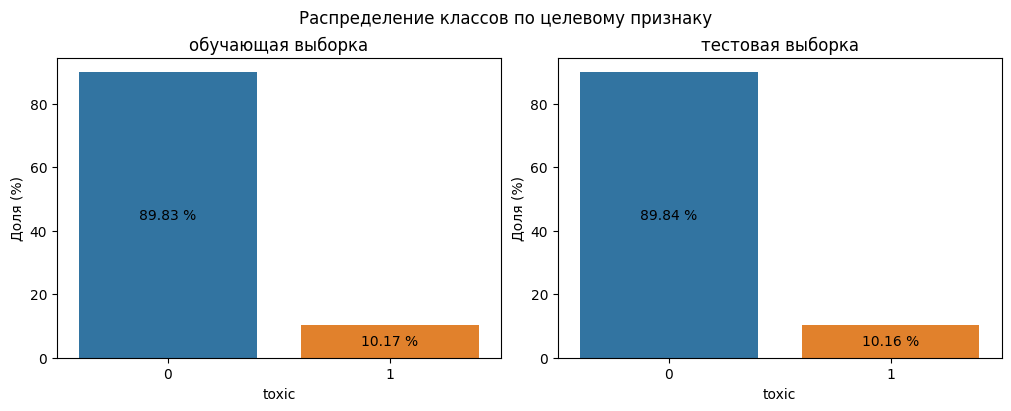

In [46]:
# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

# строим диаграммы распределения для выборок
ax = axes[0]
plt.sca(ax)
plot_class_balance(y_train)
title = ax.get_title()
ax.set_title('обучающая выборка')

ax = axes[1]
plt.sca(ax)
plot_class_balance(y_test)
ax.set_title('тестовая выборка')

# заголовок графиков
fig.suptitle(title);

Выборки — стратифицированные.

### Создание пайплайна

Для обучения и проверки качества моделей классификации создадим пайплайн. Использование пайплайна необходимо, чтобы избежать утечки целевого признака при кросс-валидации на этапе предварительной оценки качества моделей на обучающей выборке и подбора оптимальных значений гиперпараметров.

- Для подготовки данных используем `ColumnTransformer`, который позволяет применить различные преобразования к разным признакам. Применим стандартизацию к признаку `num_words` (длина комментария в словах), а остальные признаки (эмбеддинги CLS-токена из модели BERT) оставим без изменений.

- В качестве классификатора в шаблонном пайплайне используем дамми-модель классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя информацию о распределении классов в обучающей выборке.

In [47]:
# дамми-модель классификации 
dummy_model = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE
)

# обработчик данных
preprocessor = ColumnTransformer(
    [('scaler', StandardScaler(), ['num_words'])], 
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False,
)

# создаём пайплайн модели
dummy_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', dummy_model)
])

print('Шаблон пайплайна для моделей:')
dummy_pipe

Шаблон пайплайна для моделей:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 DummyClassifier(random_state=42, strategy='stratified'))])

### Выводы

Исходные данные с текстами комментариев и разметкой об их токсичности обработаны и подготовлены к использованию для обучения и оценки качества моделей.

1. Выполнена **предварительная обработка** данных:
    - Удалён столбец со значениями номеров комментариев (старый индекс).
    - Тексты приведены к нижнему регистру и очищены от URL, email, HTML-тегов и небуквенных символов.

2. Установлено, что все тексты в корпусе на **английском языке**.

3. Проведена **дополнительная обработка** текстов, учитывающая язык текстов — английский.
    - Тексты очищены от нелатинских символов, удалены диакритические знаки.
    - Из корпуса удалены пустые тексты, появившиеся в результате обработки.

4. С помощью предобученной модели BERT (вариант `bert-base-uncased`) для каждого текста получен эмбеддинг CLS-токена — вектор размерностью 768. Эти эмбеддинги будут использованы в качестве набора признаков для обучения ML моделей.

5. К данным для обучения ML моделей добавлен **дополнительный признак** — количество слов в комментарии.

6. Данные разделены на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.

7. Подготовлен шаблон **пайплайна** для обучения и проверки качества моделей классификации. Использование пайплайна необходимо, чтобы избежать утечки целевого признака при кросс-валидации на этапе предварительной оценки качества моделей на обучающей выборке и подбора оптимальных значений гиперпараметров.

    - Подготовка данных для модели осуществляется с помощью `ColumnTransformer`, который применяет стандартизацию с помощью `StandardScaler` к признаку `num_words` (количество слов в комментарии), а остальные признаки (эмбеддинги CLS-токена из модели BERT) оставляет без изменений.

    - В качестве классификатора в шаблонном пайплайне используется дамми-модель классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке.

## Обучение моделей

### Logistic Regression

Логистическая регрессия — базовая модель бинарной классификации.

Для учёта дисбаланса классов зададим параметр `class_weight='balanced'`.

Чтобы попробовать разные варианты регуляризации (L1 или L2), нужно использовать `solver='liblinear'`, при этом поскольку датасет большой, то надо увеличить максимальное число итераций алгоритма `max_iter` (значение по умолчанию — 100).

In [48]:
# модель
logreg = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# создаём пайплайн модели
logreg_pipe = clone(dummy_pipe).set_params(
    estimator = logreg
)

print('Пайплайн модели:')
logreg_pipe

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [49]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    logreg_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6488

CPU times: user 236 ms, sys: 544 ms, total: 780 ms
Wall time: 27.2 s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. Для модели логистической регрессии подберём следующие параметры: `penalty` — тип регуляризации (L1 или L2) и `C` — силу регуляризации.

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Также измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [50]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    logreg_pipe_best_params = {
        'estimator__penalty': 'l2',
        'estimator__C': 0.2, 
    }

    # лучшая модель
    logreg_pipe = logreg_pipe.set_params(**logreg_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_logreg_pipe = cross_val_score(
        logreg_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        n_jobs=2,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__penalty': ['l1', 'l2'],
        'estimator__C': [0.05] + np.arange(0.1, 1.1, 0.1).tolist() +  [2],
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        logreg_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        n_jobs=-1,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    logreg_pipe_best_params = grid_search.best_params_
    
    # лучшая модель
    logreg_pipe = logreg_pipe.set_params(**logreg_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_logreg_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_logreg_pipe = %timeit -t -o -n 1 -r 1 -q \
    logreg_pipe.fit(X_train, y_train)
fit_time_logreg_pipe = fit_time_logreg_pipe.average

print('Пайплайн модели:')
display(logreg_pipe)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
      f'{cv_score_logreg_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_logreg_pipe:.2f} s')
print()

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 LogisticRegression(C=0.2, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6544
Время обучения модели: 7.69 s

CPU times: user 7.82 s, sys: 499 ms, total: 8.32 s
Wall time: 30.7 s


### Linear SVM

Попробуем использовать для классификации комментариев метод опорных векторов (SVM). Поскольку данных и признаков много, то используем более быструю реализацию этого метода с помощью градиентного спуска в классе `SGDClassifier` с указанием функции потерь `loss='hinge'`. Для учёта дисбаланса классов также зададим параметр `class_weight='balanced'`.

In [51]:
# модель
svm = SGDClassifier(
    loss='hinge',
    class_weight='balanced',
    random_state=RANDOM_STATE,
)

# создаём пайплайн модели
svm_pipe = clone(dummy_pipe).set_params(
    estimator = svm
)

print('Пайплайн модели:')
svm_pipe

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 SGDClassifier(class_weight='balanced', random_state=42))])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [52]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    svm_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6604

CPU times: user 109 ms, sys: 300 ms, total: 410 ms
Wall time: 7.27 s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. Подберём параметр `alpha`, который регулирует силу регуляризации и скорость обучения.

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Также измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [53]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    svm_pipe_best_params = {
        'estimator__penalty': 'l2',
        'estimator__alpha': 1e-4,
    }

    # лучшая модель
    svm_pipe = svm_pipe.set_params(**svm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_svm_pipe = cross_val_score(
        svm_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__penalty': ['l1', 'l2'],
        'estimator__alpha': [10**(-n) for n in range(3, 8)],
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        svm_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        n_jobs=-1,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    svm_pipe_best_params = grid_search.best_params_

    # лучшая модель
    svm_pipe = svm_pipe.set_params(**svm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_svm_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_svm_pipe = %timeit -t -o -n 1 -r 1 -q \
    svm_pipe.fit(X_train, y_train)
fit_time_svm_pipe = fit_time_svm_pipe.average

print('Пайплайн модели:')
display(svm_pipe)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
      f'{cv_score_svm_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_svm_pipe:.2f} s')
print()

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 SGDClassifier(class_weight='balanced', random_state=42))])

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6604
Время обучения модели: 2.46 s

CPU times: user 2.54 s, sys: 106 ms, total: 2.64 s
Wall time: 6 s


### CatBoost

Применим для классификации комментариев продвинутую модель градиентного бустинга на деревьях решений — CatBoost. Для учёта дисбаланса классов зададим параметр `auto_class_weights=Balanced`. По умолчанию в CatBoost задано число итераций алгоритма градиентного бустинга, равное 1000 (параметр `iterations`). Из-за этого модель обучается слишком долго, поэтому уменьшим количество итераций до 100.

In [54]:
# инициализируем модель
catboost_clf = CatBoostClassifier(
    iterations=100,
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    thread_count=-1,
    verbose=False,
)

# создаём пайплайн модели
catboost_pipe = clone(dummy_pipe).set_params(
    estimator = catboost_clf
)

print('Пайплайн модели:')
catboost_pipe

Пайплайн модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 <catboost.core.CatBoostClassifier object at 0x7f36c8c8b940>)])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [55]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    catboost_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6499

CPU times: user 6min 48s, sys: 18.8 s, total: 7min 6s
Wall time: 2min 57s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. 

Подберём параметр  `depth` — глубину отдельного дерева в ансамбле. По умолчанию `depth=6`.

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Кроме того, измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [56]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    catboost_pipe_best_params = {
        'estimator__depth': 7,
    }

    # лучшая модель
    catboost_pipe = catboost_pipe.set_params(**catboost_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_catboost_pipe = cross_val_score(
        catboost_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__depth': range(3, 9),
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        catboost_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    catboost_pipe_best_params = grid_search.best_params_

    # лучшая модель
    catboost_pipe = catboost_pipe.set_params(**catboost_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_catboost_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_catboost_pipe = %timeit -t -o -n 1 -r 1 -q \
    catboost_pipe.fit(X_train, y_train)
fit_time_catboost_pipe = fit_time_catboost_pipe.average

print('Параметры лучшей модели:')
print(catboost_pipe_best_params)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
    f'{cv_score_catboost_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_catboost_pipe:.2f} s')
print()

Параметры лучшей модели:
{'estimator__depth': 7}
Метрика F1 модели при кросс-валидации на обучающей выборке: 0.6578
Время обучения модели: 60.96 s

CPU times: user 13min 48s, sys: 31.2 s, total: 14min 19s
Wall time: 5min 42s


### Выбор лучшей модели

Сведём результаты обучения моделей в итоговую таблицу. В таблице будут следующие поля:
- `model_class` — класс модели,
- `pipeline` — пайплайн модели с оптимальными гиперпараметрами,
- `cv_f1` — значение метрики *F1* при кросс-валидации на обучающей выборке,
- `fit_time_s` — время обучения модели на обучающей выборке (в секундах).

In [57]:
# столбцы таблицы
columns = [
    'model_class',
    'pipeline',
    'cv_f1',
    'fit_time_s'
]

# формируем таблицу
results = pd.DataFrame(
    [
        [
            'LogisticRegression',
            str(logreg_pipe[-1]),
            cv_score_logreg_pipe,  
            fit_time_logreg_pipe,
        ],
        [
            'SGDClassifier',
            str(svm_pipe[-1]),
            cv_score_svm_pipe, 
            fit_time_svm_pipe,
        ],
        [
            'CatBoostClassifier',
            catboost_pipe[-1].__class__.__name__ 
            + '(' 
            + ', '.join([f'{k}={v!r}' for k, v in catboost_pipe[-1].get_params().items()]) 
            + ')',
            cv_score_catboost_pipe,  
            fit_time_catboost_pipe,
        ],
    ],
    columns=columns
).set_index('model_class')

In [58]:
# выводим таблицу
(results
 .sort_values(by='cv_f1', ascending=False)
 .style
 .format({
     'cv_f1': '{:.4f}',
     'fit_time_s': '{:.2f}',
 })
 .highlight_min('cv_f1', color='pink')
 .highlight_max('cv_f1', color='lightgreen') 
 .highlight_min('fit_time_s', color='lightgreen')
 .highlight_max('fit_time_s', color='pink') 
)

,pipeline,cv_f1,fit_time_s
model_class,,,
SGDClassifier,"SGDClassifier(class_weight='balanced', random_state=42)",0.6604,2.46
CatBoostClassifier,"CatBoostClassifier(iterations=100, verbose=False, auto_class_weights='Balanced', random_state=42, depth=7)",0.6578,60.96
LogisticRegression,"LogisticRegression(C=0.2, class_weight='balanced', max_iter=1000, random_state=42, solver='liblinear')",0.6544,7.69


К сожалению, ни одна из моделей не показала результаты, удовлетворяющие заданному требованию: значение метрики *F1* > 0.75.

Максимальное значение метрики *F1* при кросс-валидации на обучающей выборке и минимальное время обучения среди рассмотренных моделей показала линейная модель **SVM** `SGDClassifier` с взвешиванием классов и остальными параметрами по умолчанию (L2-регуляризация, сила регуляризации `alpha=1e-4`). Возможно, что модель SVM с нелинейным ядром показала бы ещё лучший результат, но из-за её высокой вычислительной сложности время обучения модели на полном датасете было бы неприемлемо большим.

Модель **CatBoost** `CatBoostClassifier` с количеством итераций градиентного бустинга `iterations=100`, заданной максимальной глубиной деревьев `depth=7` и автоматическим подбором весов классов (`auto_class_weights='Balanced'`) и скорости обучения (`learning_rate`), а также **логистическая регрессия** `LogisticRegression` с взвешиванием классов и усиленной L2-регуляризацией (параметр `C=0.2`) показали результаты ненамного хуже. Однако для модели **CatBoost** время обучения существенно больше, чем для других моделей, из-за её сложности.

По критерию максимального значения метрики *F1* **лучшая модель** среди рассмотренных — это линейная модель **SVM** `SGDClassifier` с взвешиванием классов и остальными параметрами по умолчанию.

In [59]:
# лучшая модель
best_model = svm_pipe

print('Пайплайн лучшей модели:')
best_model

Пайплайн лучшей модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 SGDClassifier(class_weight='balanced', random_state=42))])

### Выводы

1. Обучены и проверены на обучающей выборке путём кросс-валидации модели 3-х классов, включённые в построенный пайплайн:
    - логистическая регрессия `LogisticRegression`,
    - модель классификации методом опорных векторов (SVM) с использованием градиентного спуска `SGDClassifier`
    - модель классификации с использованием градиентного бустинга на деревьях решений CatBoost `CatBoostClassifier`.

2. При построении моделей использовано взвешивание классов для учёта их дисбаланса в данных.

3. Для каждой модели подобраны оптимальные значения гиперпараметров, максимизирующие метрику *F1* при кросс-валидации на обучающей выборке.

4. Измерено время обучения каждой модели на обучающей выборке.

5. По критерию максимального значения метрики *F1* при кросс-валидации на обучающей выборке выбрана **лучшая модель** — линейная модель **SVM** `SGDClassifier`. Дополнительное преимущество этой модели — малое время обучения. Недостаток модели — сложность интерпретации результатов по сравнению с логистической регрессией, т.к. без использования дополнительных средств модель не выдаёт вероятности принадлежности к классу.

## Тестирование лучшей модели

### Проверка качества модели

Получим предсказания лучшей модели на тестовой выборке и проверим её качество по метрике *F1*.

In [60]:
# делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# метрика F1 на тестовой выборке
best_model_test_score = f1_score(y_test, y_pred)

print(f'Метрика F1 лучшей модели на тестовой выборке: {best_model_test_score:.4f}')

Метрика F1 лучшей модели на тестовой выборке: 0.6843


Как и следовало ожидать, значение метрики *F1* на тестовой выборке не дотягивает до заданного уровня *F1* > 0.75. Тем не менее, оно получилось даже выше, чем при кросс-валидации на обучающей выборке. Значит, модель не переобучилась и качество её предсказаний стабильно.

### Проверка на адекватность

Проверим лучшую модель на адекватность, сравнив её с дамми-моделью классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя информацию о распределении классов в обучающей выборке. Для этого рассчитаем метрику *F1* дамми-модели на тестовой выборке.

Модель можно считать адекватной, если качество её предсказаний на тестовой выборке существенно лучше, чем у дамми-модели. 

*Примечание:* `DummyClassifier` *с параметрами по умолчанию всегда предсказывает мажорный класс, поэтому когда старший класс — минорный, то и Precision = 0, и Recall = 0, а значит и F1 = 0. Поэтому логичнее использовать для сравнения* `DummyClassifier(strategy='stratified')`.

In [61]:
# обучаем дамми-модель на обучающей выборке
dummy_pipe.fit(X_train, y_train)

# делаем предсказания на тестовой выборке
y_pred_dummy = dummy_pipe.predict(X_test)

# метрика F1 на тестовой выборке
dummy_model_test_score = f1_score(y_test, y_pred_dummy)

print('Пайплайн дамми-модели:')
display(dummy_pipe)

print(f'Метрика F1 дамми-модели на тестовой выборке: {dummy_model_test_score:.4f}')

Пайплайн дамми-модели:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['num_words'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Метрика F1 дамми-модели на тестовой выборке: 0.0778


Дамми-модель показала намного худшее качество. Значит, выбранная лучшая модель адекватно классифицирует комментарии по токсичности.

### Анализ ошибок модели

Посмотрим на матрицу ошибок лучшей модели на тестовой выборке. Для этого используем пользовательскую функцию `plot_confusion_matrix()`, указав аргумент `normalize='all'` для нормировки на размер выборки.

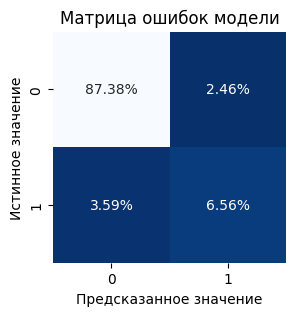

In [62]:
# строим матрицу ошибок модели
plot_confusion_matrix(y_test, y_pred, normalize='all');

По матрице ошибок сразу же видно, что *Recall* < *Precision*.

Рассчитаем метрики качества бинарной классификации:

- *Accuracy* — доля правильных предсказаний модели. 
- *Precision* — доля верно классифицированных объектов класса 1 от всех объектов, которые модель отнесла к классу 1.
- *Recall* — доля верно классифицированных объектов класса 1 от всех объектов, принадлежащих к классу 1.
- *Specificity* — доля верно классифицированных объектов класса 0. 
- *F1* — среднее гармоническое *Precision* и *Recall*.

In [63]:
# считаем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
f1 = best_model_test_score

# объединяем значения в DataFrame
scores = pd.DataFrame(
    {'значение': [accuracy, precision, recall, specificity, f1]}, 
    index=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
)
scores.round(4)

,значение
Accuracy,0.9395
Precision,0.7273
Recall,0.6462
Specificity,0.9726
F1,0.6843


Анализ метрик качества классификации показывает:
- В целом модель даёт верные предсказания в ≈94% случаев (метрика *Accuracy*). Но в ситуации дисбаланса классов этот показатель неадекватно отражает качество модели. 
- Среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались ≈73% (метрика *Precision*). Это означает, что в ≈27% случаев отмеченный моделью как токсичный комментарий на самом деле нормальный.
- Модель смогла верно выявить всего лишь ≈65% токсичных комментариев (метрика *Recall*). Соответственно, в ≈35% случаев модель не смогла распознать токсичный комментарий.
- Модель верно классифицировала ≈97% нормальных комментариев как не токсичные. Соответственно, лишь в ≈3% случаев модель классифицирует нормальный комментарий как токсичный.

Таким образом, модель недостаточно хорошо выявляет токсичные комментарии, а также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором. При необходимости соотношение *Precision*/*Recall* можно настроить подбором порога классификации, если вместо меток классов получать из модели вероятности принадлежности к ним. Но в случае модели SVM для получения вероятностей нужно использовать калибровку вероятностей с помощью `CalibratedClassifierCV`. В редких случаях модель также может классифицировать нормальный комментарий как токсичный, тогда тоже может потребоваться вмешательство модератора.

### Оценка значимости признаков

Посмотрим, какие признаки наиболее важны для лучшей модели. Оценим значимость признаков для модели методом расчёта значений Шепли с помощью библиотеки SHAP. Метод SHAP также позволяет оценить направленность влияния значений признаков на предсказания модели.

Подготовим данные для оценки важности признаков:
- Возьмём из пайплайна лучшей модели трансформер для подготовки данных и преобразуем с его помощью тренировочную и тестовую выборки, добавив в них названия входных признаков.
- Повторно обучим лучшую модель на тренировочной выборке.

In [64]:
# лучшая модель
best_estimator = clone(best_model['estimator'])
# обработчик для подготовки данных из пайплайна лучшей модели
best_preprocessor = clone(best_model[:-1])

# преобразуем тренировочную выборку
X_train_transformed = best_preprocessor.fit_transform(X_train, y_train)
# получаем из обработчика названия признаков
feature_names_out = best_preprocessor.get_feature_names_out()
# добавляем в тренировочную выборку названия признаков
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names_out)

# преобразуем тестовую выборку
X_test_transformed = best_preprocessor.transform(X_test)
# добавляем в тестовую выборку названия признаков
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_out)

# повторно обучаем модель на тренировочной выборке
best_estimator.fit(X_train_transformed, y_train);

Поскольку у нас линейная модель, можно использовать `LinearExplainer`.

In [65]:
# инициализируем объект explainer
shap_explainer = shap.LinearExplainer(best_estimator, X_train_transformed)

In [66]:
# вычисляем значения Шепли для тестовой выборки
shap_values = shap_explainer(X_test_transformed)

Выведем топ-10 признаков, которые сильнее всего влияют на факт классификации моделью комментария как токсичного. Используем для этого пользовательскую функцию для визуализации значимости признаков для модели `plot_feature_importance()`.

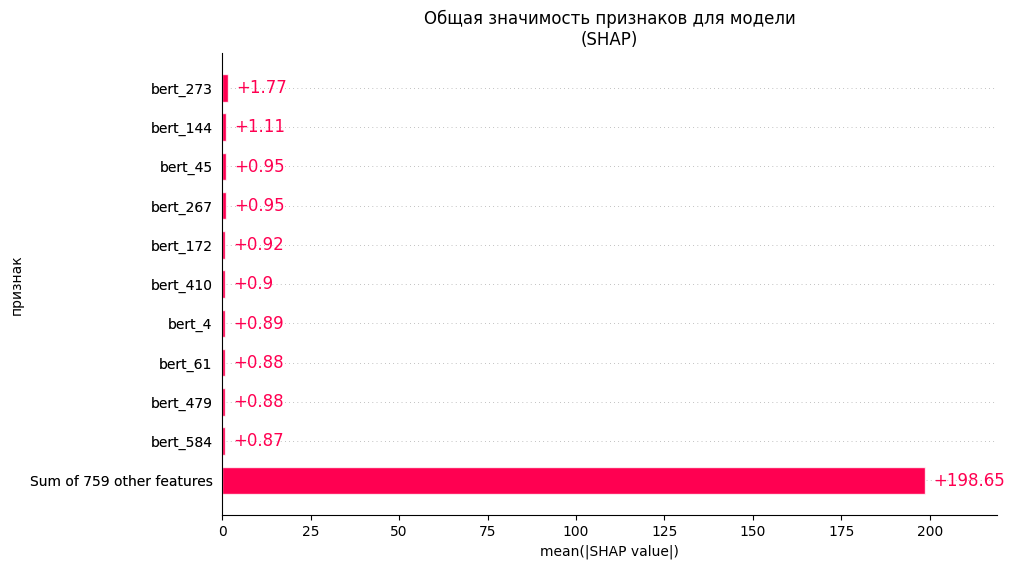

In [67]:
# количество наиболее важных признаков
top = 10 + 1  # топ-10 + все остальные

# строим график общей значимости признаков
ax = shap.plots.bar(shap_values, max_display=top, show=False) 

# оформляем график
ax.figure.set_size_inches(10, 6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.label.set_size(10)  
ax.set_ylabel('признак')
ax.set_title('Общая значимость признаков для модели\n(SHAP)');

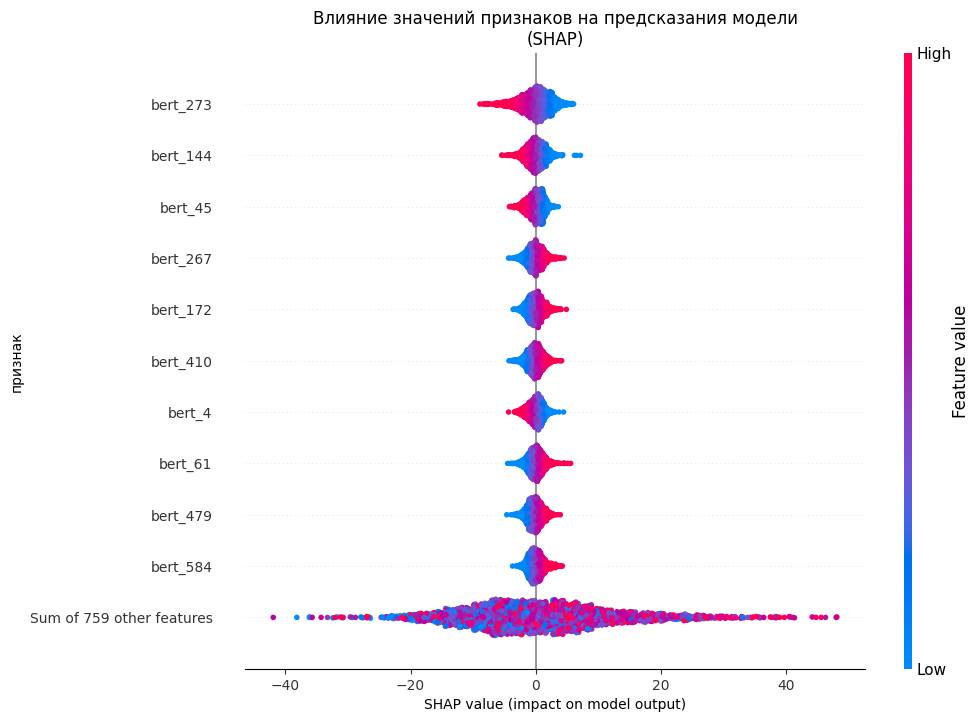

In [68]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака
ax = shap.plots.beeswarm(shap_values, max_display=top, show=False)

# оформляем график
ax.figure.set_size_inches(10, 8)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.label.set_size(10) 
ax.set_ylabel('признак')
ax.set_title('Влияние значений признаков на предсказания модели\n(SHAP)');

Среди признаков (компонентов вектора эмбеддинга CLS-токена, полученного из модели BERT) нет доминирующих по значимости для модели классификации. Всего таких признаков 768. 

Посмотрим также, насколько значим для модели оказался добавленный признак `num_words` (количество слов в комментарии). Посмотрим, на каком месте по значимости оказался этот признак.

In [69]:
# оценки значимости признаков
feature_importances = np.mean(shap_values.abs.values, axis=0)
# названия признаков
feature_names = np.array(shap_values.feature_names)
# сортируем признаки по убыванию значимости
idx_sort_desc = feature_importances.argsort()[::-1]
feature_names = feature_names[idx_sort_desc]
print('Порядковый номер признака \'num_words\' по значимости:', 
      int(np.nonzero(feature_names == 'num_words')[0]) + 1)

Порядковый номер признака 'num_words' по значимости: 40


Значимость признака не высокая, но выше, чем у большинства остальных признаков. Проверим характер влияния значения признака на предсказания модели.

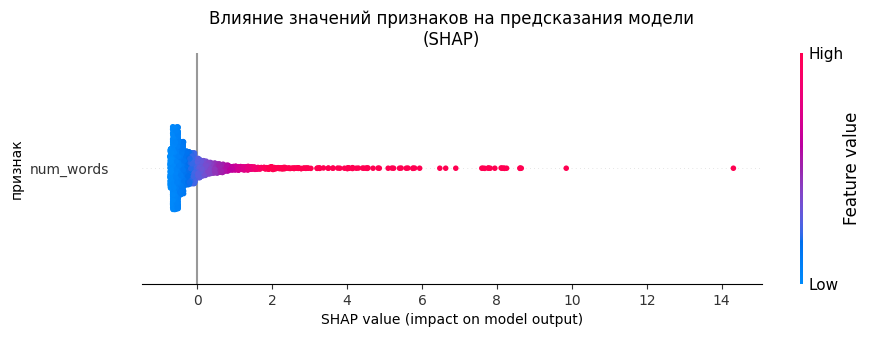

In [70]:
# строим график, который показывает влияние значений признаков 
# на предсказания целевого признака
ax = shap.plots.beeswarm(shap_values[:,[0]], show=False)

# оформляем график
ax.figure.set_size_inches(10, 3)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.label.set_size(10) 
ax.set_ylabel('признак')
ax.set_title('Влияние значений признаков на предсказания модели\n(SHAP)');

Направленность влияния признака неожиданно оказалась противоположной той, что была обнаружена на этапе исследовательского анализа: большая длина комментария повышает вероятность его классификации как токсичного. 

### Выводы

1. Значение метрики *F1* лучшей модели классификации — линейной модели **SVM** `SGDClassifier` — на тестовой выборке получилось 0.68, что ниже заданного уровня 0.75. Таким образом, модель не удовлетворяет требованиям заказчика. Получается, что ванильная модель BERT не справляется с задачей извлечения из текстов комментариев признаков, которые позволили бы классифицировать комментарии на токсичные и нетоксичные с нужным значением метрики *F1*.

2. Проверка лучшей модели на адекватность показала, что качество предсказаний модели намного лучше, чем у дамми-модели, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке. Таким образом, модель в принципе адекватна, но по качеству не дотягивает до требуемого уровня.

3. Анализ ошибок модели на тестовой выборке показал, что модель смогла верно выявить только ≈65% токсичных комментариев, при этом среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались ≈73%. Таким образом, модель недостаточно хорошо выявляет токсичные комментарии, а также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором.

4. Оценка значимости признаков для модели показала, что среди компонентов векторного представления смысла комментария в виде эмбеддинга CLS-токена ни один не является доминирующим, все они вносят свой небольшой вклад в результат классификации. Значимость признака "количество слов в комментарии" не высокая, но выше, чем у большинства остальных признаков, а направление его влияния на результат классификации — положительное, что говорит о том, что чем больше слов в комментарии, тем выше вероятность того, что он токсичный.

## Общий вывод по проекту

1. В проекте была поставлена **задача**: используя корпус текстов комментариев с разметкой об их токсичности, построить модель классификации комментариев на позитивные (нормальные) и негативные (токсичные). 
    - Требования к модели: значение метрики качества *F1* не меньше 0.75. 
    
2. Исходный датасет содержит тексты более 159 тысяч комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0). Предсказание целевого признака, принимающего значения 0 и 1 — это задача **бинарной классификации**.

3. Тексты комментариев обработаны и подготовлены к использованию для обучения и оценки качества моделей.
    - Установлено, что все тексты в корпусе на **английском языке**.
    - Выполнена **обработка текстов**:
        - приведение символов к нижнему регистру,
        - очистка от URL, email, HTML-тегов, IP-адресов, экранированных специальных символов,
        - удаление пустых текстов, появившихся в результате обработки.
    - С помощью предобученной модели BERT (вариант `bert-base-uncased`) для каждого текста получен эмбеддинг CLS-токена — вектор размерностью 768. Эти эмбеддинги будут использованы в качестве набора признаков для обучения ML моделей.
    - К данным для обучения ML моделей добавлен дополнительный признак — длина текста в словах.
  
4. Обнаружен **дисбаланс классов** по значению целевого признака: доля токсичных комментариев составляет всего ≈10%. Этот факт учтён при подготовке выборок и построении ML моделей:
    - Данные разделены на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.
    - При построении моделей использовано взвешивание классов.

5. Обучены и проверены на обучающей выборке путём кросс-валидации **ML модели** 3-х классов: логистическая регрессия `LogisticRegression`, линейная модель классификации методом опорных векторов (SVM) с использованием градиентного спуска `SGDClassifier` и  модель классификации с использованием градиентного бустинга на деревьях решений CatBoost `CatBoostClassifier`.
    - Модели включены в пайплайн, содержащий `ColumnTransformer`, который применяет стандартизацию с помощью `StandardScaler` к признаку `num_words` (количество слов в комментарии), а остальные признаки (эмбеддинги CLS-токена из модели BERT) оставляет без изменений. Использование пайплайна для преобразования данных необходимо, чтобы избежать утечки целевого признака при кросс-валидации.
    - Для каждой модели подобраны оптимальные значения гиперпараметров, максимизирующие метрику *F1* при кросс-валидации на обучающей выборке.
    - Измерено время обучения каждой модели на обучающей выборке.

6.  Выбрана **лучшая модель** по критерию максимального значения метрики *F1* при кросс-валидации на обучающей выборке — линейная модель **SVM** `SGDClassifier` с взвешиванием классов и остальными параметрами по умолчанию. Дополнительное преимущество этой модели — малое время обучения. Недостаток модели — сложность интерпретации результатов по сравнению с логистической регрессией, т.к. без использования дополнительных средств модель не выдаёт вероятности принадлежности к классу.

7. Качество лучшей модели классификации проверено на тестовой выборке.
    - Значение метрики *F1* модели на тестовой выборке получилось 0.68, что ниже заданного уровня 0.75. 
    - Тем не менее, качество предсказаний модели намного лучше, чем у дамми-модели, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке. Таким образом, модель в принципе адекватна, но по качеству не дотягивает до требуемого уровня.
    - Модель смогла верно выявить только ≈65% токсичных комментариев, при этом среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались ≈73%. 

**Итоговый вывод:**

Построенная модель классификации недостаточно хорошо выявляет токсичные комментарии, а также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором. Таким образом, модель не удовлетворяет требованиям заказчика по критерию метрики *F1*. Получается, что ванильная модель BERT не справляется с задачей извлечения из текстов признаков, которые позволили бы качественно классифицировать комментарии на токсичные и нетоксичные.

**Рекомендации по дальнейшему повышению качества модели:**
Для повышения качества классификации можно попробовать:
- Дообучить модель BERT на данных из датасета с комментариями (т.е. провести fine-tuning модели). Однако обучение нейросети с большим количеством параметров требует очень больших вычислительных ресурсов.
- Использовать для извлечения признаков уже готовый, дообученный соответствующим образом, вариант модели BERT, либо другую языковую модель, которых существует множество. Например, модель RoBERTa, которая должна показать лучшие результаты, чем BERT.
- Использовать для модели классификации признаки на основе значений TF-IDF для отдельных слов в тесте комментариев, что даже проще с точки зрения требуемых вычислительных ресурсов.